<a href="https://colab.research.google.com/github/TheAmirHK/Portfolio-analysis-and-optimization/blob/main/Portfolio_optimization_via_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" This code simulates a portfolio consisting of a variety of stocks and allocates the optimal portfolio with the maximum Sharpe ratio.
Afterwards, the number of optimal share volumes is calculated, and the portfolio is compared to the market (e.g. GSPC) performance.
"""

import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# A function to download stocks' adjusted close price
def receive_data(tickers, start, end):
    adj_close_df = pd.DataFrame()
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start, end, progress=False)
        adj_close_df[ticker] = data["Adj Close"]
    return adj_close_df

In [ ]:
# A function to normalize prices
def daily_return(data):
    log_returns = data.pct_change().dropna()
    return log_returns

In [ ]:
# One portfolio test and evaluation
def evaluation (data, Rf = 0.02):
    result = pd.DataFrame()
    log_return = daily_return(data)
    result["ExpRet"] = log_return.mean()*252
    result["ExpVol"] = log_return.std() *np.sqrt(252)
    result["ExpSha"] = (result["ExpRet"] -Rf ) / result["ExpVol"]
    return result

In [ ]:
# Let's run a MonteCarlo simulation_Random based simulation
def Simulation(data, NMC, Rf=0.02):

    Stock_number = len(data.T)

    log_returns = daily_return(data)

    # Define an empty weight matrix
    WeightList = np.zeros((NMC,Stock_number))

    # Define an empty expected retrun matrix
    ExpRet = np.zeros((NMC))

    # Define an empty expected volatility matrix
    ExpVol = np.zeros((NMC))

    # Define an empty expected retrun matrix
    ExpSha = np.zeros((NMC))

    for idx in tqdm(range(NMC)):
        randomWeights = np.array(np.random.random(Stock_number))
        norm_randomWeights = randomWeights/np.sum(randomWeights)
        WeightList[idx] = norm_randomWeights
        ExpRet[idx] = np.sum(WeightList[idx]*log_returns.mean()*252)
        ExpVol[idx] = np.sqrt(WeightList[idx].T @ log_returns.cov() *252 @ WeightList[idx])
        ExpSha[idx] = (ExpRet[idx] - Rf)/ExpVol[idx]

    # Save simulation data as dataFrame
    MCData = [ExpRet,ExpVol,ExpSha]

    MCData = pd.DataFrame(MCData).T

    MCData.columns = ['ExpRet','ExpVol','ExpSha']

    MCData[list(data.columns)] = WeightList

    # Locate the portfolio with Maximum Sharp Ratio
    MaxSharpRatio = MCData.loc[MCData['ExpSha'].idxmax()]

    # Locate the portfolio with Minimum Volatility
    MinVolatility = MCData.loc[MCData['ExpVol'].idxmin()]

    # Locate the portfolio with Maximum Sharpe
    MaxReturn = MCData.loc[MCData['ExpRet'].idxmax()]

    # Plot the data on a Scatter plot.
    plt.scatter(
        x = MCData['ExpRet'],
        y = MCData['ExpVol'],
        c=MCData['ExpSha'],
        cmap='RdYlBu',
        edgecolor='black'
    )

    # Give the Plot some labels, and titles.
    plt.title('Portfolio ExpRet Vs. Expected Risk')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Expected Return')
    plt.ylabel('Expected Volatility')

    # Plot the Max Sharpe Ratio, using a `Red Star`.
    plt.scatter(
        MaxSharpRatio['ExpRet'],
        MaxSharpRatio['ExpVol'],
        marker= 'x',
        color='r',
        s=100,
        label="MaxSharpRatio"
    )

    # Plot the Min Volatility, using a `Blue Star`.
    plt.scatter(
        MinVolatility['ExpRet'],
        MinVolatility['ExpVol'],
        marker='x',
        color='b',
        s=100,
        label="MinVolatility"
    )

    # Plot the Max return, using a `Blue Star`.
    plt.scatter(
        MaxReturn['ExpRet'],
        MaxReturn['ExpVol'],
        marker='x',
        color='y',
        s=100,
        label="MaxReturn"
    )

    # Finally, show the plot.
    plt.show()

    return MaxSharpRatio

In [ ]:
# Calculate optimal share volumes using the obtained weights from simulation.
def share_volume(stock_data, results, wealth):
    Optimal_weights = results.iloc[3:]
    Optimal_weights = np.array(Optimal_weights)
    evaluation = pd.DataFrame()
    evaluation['Price'] = stock_data.iloc[-1]
    evaluation['Optimal Weights'] = Optimal_weights.T
    evaluation['Optimal Volume'] = (evaluation['Optimal Weights'] *wealth / evaluation['Price'])
    evaluation['Optimal Volume'] = evaluation['Optimal Volume'].apply(math.floor)
    evaluation['Total pay'] = evaluation['Optimal Volume'] * evaluation['Price']
    left = wealth - np.sum(evaluation['Total pay'])
    print("Not allocated budegt: %0.2f $ out of %0.2f $"%(left,wealth ))
    return evaluation

In [ ]:
# Compare portfolio performance against market
def portfolio_vs_market(simulation_results, market_data):

    portfolio = simulation_results.iloc[:3]
    market_ev = evaluation(market_data)

    df = pd.DataFrame({
    'Portfolio Vs Market': ['ExpRet', 'ExpVol', 'ExpSha'],
    'Portfolio': portfolio.values.tolist(),
    'Market': (market_data.iloc[0]).values.tolist()
    })

    # plotting graph
    df.plot(x="Portfolio Vs Market", y=["Portfolio", "Market"], kind="bar", grid=True)
    plt.show()

    return

In [ ]:
# Eahc individual stocks to be analyzed !
stocks = ["AAPL", "MSFT", "GOOG", "AMZN",   # Technology stocks
          "TSLA", "TM", "MBGYY", "VWAGY", "VLVLY", "GM",  # Motor manufacturing stocks
          "LLY", "JNJ", "AZN"] # Health market stocks
market = ['^GSPC'] # S&P500 index

# define the number of years to be studied
NYears = 5

# Risk-free asset rate
Rf = 0.02

# Wealth value (Budget)
wealth = 5000

# Number of simulation
NS = 500000

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
print("Start date:%str   End date:%str" %(start, end))

stock_data = receive_data(stocks, start, end)
market_data = receive_data(market, start, end)

Start date:2018-11-27 18:33:01.970395tr   End date:2023-11-26 18:33:01.970395tr


100%|██████████| 500000/500000 [15:41<00:00, 531.25it/s]


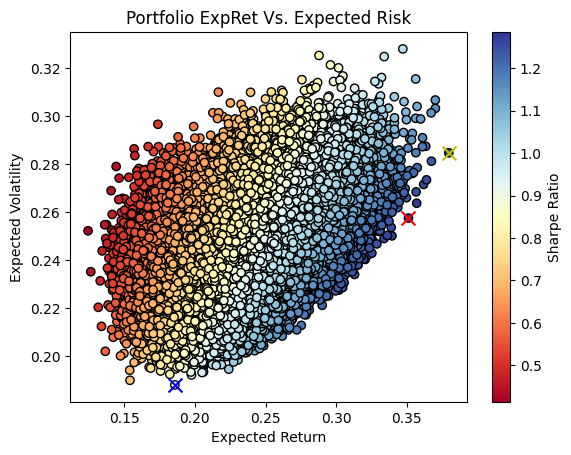

In [ ]:
# Run simulation
simulation_results = Simulation(stock_data, NS)

In [ ]:
# Calculate the share_volume
share_volume(stock_data, simulation_results, wealth)

Not allocated budegt: 981.02 $ out of 5000.00 $


,Price,Optimal Weights,Optimal Volume,Total pay
AAPL,189.970001,0.178681,4,759.880005
MSFT,377.429993,0.000607,0,0.000000
GOOG,138.220001,0.004663,0,0.000000
AMZN,146.740005,0.052586,1,146.740005
TSLA,235.449997,0.184811,3,706.349991
TM,188.300003,0.068551,1,188.300003
MBGYY,15.980000,0.017239,5,79.899998
VWAGY,12.950000,0.062358,24,310.799995
VLVLY,22.809999,0.077955,17,387.769991
GM,28.180000,0.017501,3,84.540001


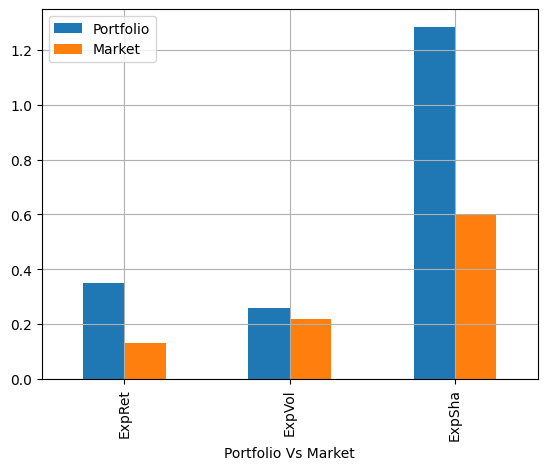

In [ ]:
# Evaluate market and optimal portfolio performances adn compare them
portfolio = simulation_results.iloc[:3]
market_ev = evaluation(market_data)
portfolio_vs_market(portfolio,market_ev)